<h2> Explore Data </h2>

In [2]:
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from typing import List, Tuple

In [3]:
import os
path = "D:/notebook/Deep Learning Course/files/"

In [9]:
files = os.listdir(path)
print(len(files))

132


In [61]:
files = [file.split('.')[0] for file in files]
for x in ['old', 'index', 'RECORDS', 'ANNOTATORS', 'SHA256SUMS', 'notes', '00735', '03665']:
    if x in files:
        files.remove(x)
files = list(set(files))
files

['04043',
 '08219',
 '08378',
 '05121',
 '08434',
 '04908',
 '05261',
 '07910',
 '07859',
 '07879',
 '08215',
 '04015',
 '08455',
 '07162',
 '04048',
 '08405',
 '05091',
 '04746',
 '06453',
 '06995',
 '06426',
 '04126',
 '04936']

In [ ]:
record_name = os.path.join(path, files[10])
record = wfdb.rdheader(record_name)
print(f"Record: {record.record_name}")
print(f"Sampling frequency: {record.fs} Hz")
print(f"Signal length: {record.sig_len} samples")
print(f"Duration: {record.sig_len/record.fs:.2f} seconds")

Record: 07859
Sampling frequency: 250 Hz
Signal length: 9205760 samples
Duration: 36823.04 seconds


In [7]:
annotations = wfdb.rdann(record_name, 'atr')
print(f"\nAnnotation file (.atr) loaded:")
print(f"Number of annotations: {len(annotations.sample)}")
print(f"Annotation symbols: {set(annotations.symbol)}")
print(f"annotation symbols : {annotations.symbol}")
print(f"annotation sample : {annotations.sample}")


Annotation file (.atr) loaded:
Number of annotations: 79
Annotation symbols: {'+'}
annotation symbols : ['+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+']
annotation sample : [    172 3077924 3126813 3144896 3236450 3272405 3373026 3385696 3491433
 3534149 3593003 3603735 3664616 3679789 3813870 3824127 3841689 3854499
 3873943 4433500 4537195 4544500 4569750 4581494 4668721 4676269 4708991
 4717972 4736918 4742277 4778243 4788054 4806612 4818981 4863752 4873479
 4900296 4911280 4928796 4941994 4966821 4980705 5012329 5020409 5067426
 5074252 5083417 5091007 5105317 5116801 5158000 5170948 5189837 5203078
 5308514 5319425 5370405 5404332 5469500 

In [18]:
channels = []
rhythms = []
for file in files:
    record_name = os.path.join(path, file)
    ann = wfdb.rdann(record_name, 'atr')
    qrs = wfdb.rdann(record_name, 'qrs')
    rhythms.append(np.unique(qrs.symbol))
    channels.append(np.unique(ann.chan))
print(rhythms)
print(channels)

[array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1')]
[array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0])]


In [ ]:
symbol = []
for file in files:
    record_name = os.path.join(path, file)
    ann = wfdb.rdann(record_name, 'atr')
    symbol.append(set(ann.symbol))
print(symbol)



[{'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}]


In [197]:
shortest_interval =[]
for file in files:
    record_name = os.path.join(path, file)
    ann = wfdb.rdann(record_name, 'atr')
    if ann.sample.shape[0] > 1:
        shortest_interval.append(np.min(ann.sample[1:]-ann.sample[:-1]))
print(shortest_interval)

[np.int64(381), np.int64(1700), np.int64(1545), np.int64(626), np.int64(624), np.int64(1174), np.int64(1530), np.int64(2062), np.int64(66017), np.int64(421), np.int64(1695), np.int64(685), np.int64(6076), np.int64(848), np.int64(4403), np.int64(12560), np.int64(4387), np.int64(1239), np.int64(2226), np.int64(883), np.int64(12347), np.int64(433), np.int64(4269)]


In [13]:
def create_training_data(path:str, file_name:str, window:int, shift:int):
    record_name = os.path.join(path, file_name)
    signal = wfdb.rdrecord(record_name)
    ann = wfdb.rdann(record_name, 'atr')
    boundary_idx = 0
    start, next_boundary = ann.sample[boundary_idx], ann.sample[boundary_idx]
    region = ann.aux_note[boundary_idx]
    data = []
    label = []
    while start+window < signal.p_signal.shape[0]:
        data.append(signal.p_signal[start:start+window,:])
        if not start < next_boundary < start + window:
            label.append(0) if region == '(N' else label.append(1)
        else:
            percent = (next_boundary - start)/window * 100
            if percent > 50:
                label.append(0) if region == '(N' else label.append(1)
            else:
                label.append(1) if region == '(N' else label.append(0)
        start += shift
        if start >= ann.sample[boundary_idx]:
            region = ann.aux_note[boundary_idx]
            if boundary_idx + 1 < len(ann.sample):
                boundary_idx += 1
        next_boundary = ann.sample[boundary_idx]
            
    return np.array(data), np.array(label)


In [15]:
index = 4
record_name = os.path.join(path, files[index])
ann = wfdb.rdann(record_name, 'atr')
record = wfdb.rdrecord(record_name)
print(ann.sample, ann.symbol, ann.aux_note)
print(len(ann.sample), len(ann.symbol), len(ann.aux_note))
print(record.p_signal.shape[0])

[     28 1843491 1844115 1849414 2305445 2316258 2416869 2424776 3435782
 3448070 3676804 3683982 3729925 3844733 3889216 3897888 4899446 4908291
 6917105 6924329 7099843 7106612 7118120 7126125 7322625 7327125 7448750
 7453750 7519625 7528250 7796000 7802000 7818875 7825750 7832125 7836000
 7841875 7845375 7856250 7875875 7901535 7919093] ['+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+'] ['(N', '(AFIB', '(N', '(AFIB', '(N', '(AFIB', '(N', '(AFIB', '(N', '(AFIB', '(N', '(AFIB', '(N', '(AFIB', '(N', '(AFIB', '(N', '(AFIB', '(N', '(AFIB', '(N', '(AFIB', '(N', '(AFIB', '(N', '(AFIB', '(N', '(AFIB', '(N', '(AFIB', '(J', '(AFIB', '(J', '(AFIB', '(J', '(AFIB', '(J', '(AFIB', '(J', '(AFIB', '(J', '(N']
42 42 42
9205760


In [16]:
x, y = create_training_data(path, files[index], 2500, 1250)
print(x.shape)
df = pd.DataFrame(y, columns=['label'])
print(df.label.value_counts())

(7363, 2500, 2)
label
1    4678
0    2685
Name: count, dtype: int64


In [134]:
ch1_cols = [f"feature_{id}" for id in range(x.shape[1])]
ch2_cols = [f"feature_{id}" for id in range(x.shape[1])]
ch1 = pd.DataFrame(x[:, :, 0], columns=ch1_cols)
ch2 = pd.DataFrame(x[:, :, 1], columns=ch2_cols)

ch1['label']=  y
ch2['label'] = y


# with pd.ExcelWriter("ecg_data.xlsx") as writer:
#     ch1.to_excel(writer, sheet_name="Channel_1", index=False)
#     ch2.to_excel(writer, sheet_name="Channel_2", index=False)

In [139]:
ch1.tail(500)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_2491,feature_2492,feature_2493,feature_2494,feature_2495,feature_2496,feature_2497,feature_2498,feature_2499,label
6863,0.975,1.015,1.035,1.060,1.105,1.120,1.155,1.175,1.195,1.230,...,0.170,0.175,0.215,0.180,0.145,0.105,0.070,0.050,0.030,0
6864,-0.010,-0.025,-0.010,0.005,0.005,-0.005,-0.005,-0.035,-0.005,0.000,...,0.085,0.150,0.155,0.175,0.205,0.215,0.210,0.235,0.225,0
6865,0.000,-0.030,-0.045,-0.060,-0.040,-0.015,-0.025,-0.045,-0.065,-0.075,...,-0.045,-0.035,-0.030,-0.050,-0.060,-0.040,-0.050,-0.040,-0.055,0
6866,0.245,0.245,0.295,0.295,0.315,0.305,0.320,0.330,0.365,0.365,...,-0.130,-0.140,-0.140,-0.135,-0.115,-0.145,-0.130,-0.145,-0.125,0
6867,-0.060,-0.060,-0.075,-0.055,-0.065,-0.080,-0.085,-0.080,-0.080,-0.095,...,1.095,1.080,1.020,1.005,0.960,0.905,0.870,0.810,0.755,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7358,-0.810,-0.830,-0.850,-0.845,-0.880,-0.870,-0.895,-0.905,-0.925,-0.945,...,0.220,0.210,0.200,0.215,0.175,0.175,0.190,0.200,0.205,0
7359,0.520,0.560,0.565,0.590,0.610,0.650,0.665,0.635,0.625,0.605,...,0.610,0.615,0.645,0.660,0.665,0.695,0.700,0.735,0.715,0
7360,0.205,0.205,0.205,0.205,0.190,0.210,0.200,0.200,0.195,0.210,...,0.160,0.150,0.155,0.145,0.140,0.160,0.140,0.130,0.150,0
7361,0.740,0.745,0.770,0.775,0.825,0.835,0.870,0.855,0.905,0.935,...,0.880,0.905,0.905,0.930,0.970,0.945,0.975,0.940,0.940,0


In [154]:
data = ch2.copy()
data['label'].value_counts()
normal = data[data['label'] == 0].iloc[:, :-1].values
af = data[data['label'] == 1].iloc[:, :-1].values

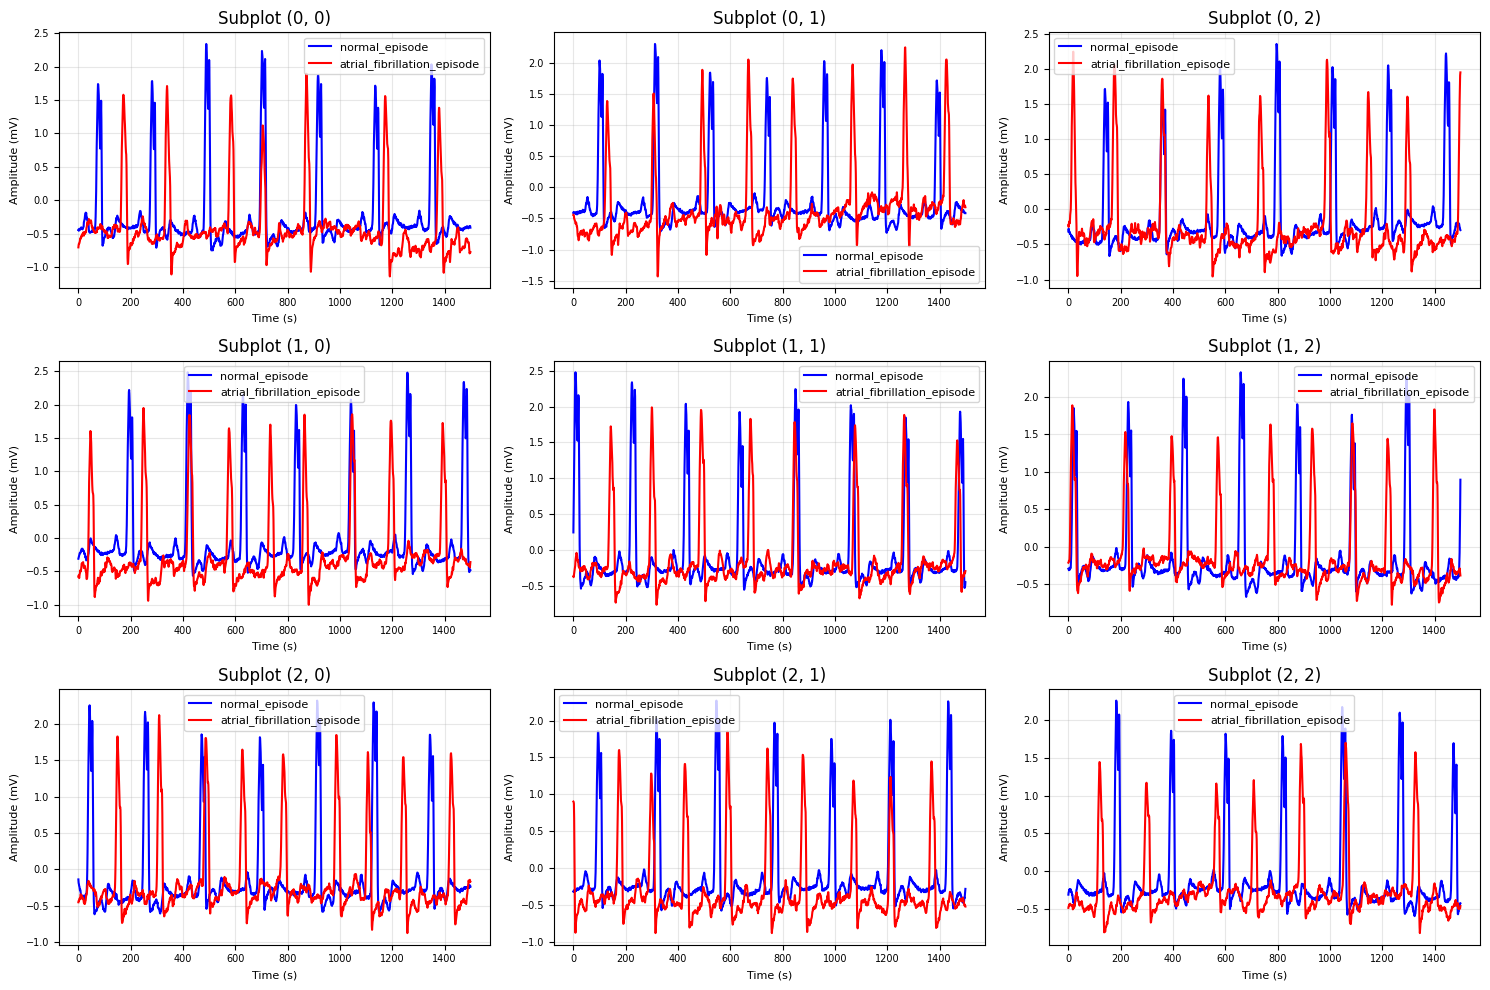

In [ ]:

# Create 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

fig_index = 350
length = 1500
time_start = 500
time_end = time_start + length if (time_start + length) < 2500 else 2500
for i in range(3):
    for j in range(3):
        axes[i, j].plot(normal[fig_index, time_start:time_end], 'b-', label='normal_episode')
        axes[i, j].plot(af[fig_index, time_start:time_end], 'r-', label='atrial_fibrillation_episode')
        axes[i, j].set_title(f'Subplot ({i}, {j})')
        axes[i, j].grid(True)

        axes[i, j].set_xlabel('Time (s)', fontsize=8)
        axes[i, j].set_ylabel('Amplitude (mV)', fontsize=8)
        axes[i, j].grid(True, alpha=0.3)
        axes[i, j].legend(fontsize=8)
        axes[i, j].tick_params(labelsize=7)

        fig_index += 1

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

In [ ]:
data = ch1.copy()
data['label'].value_counts()
normal = data[data['label'] == 0].iloc[:, :-1].values
af = data[data['label'] == 1].iloc[:, :-1].values

In [ ]:

# Create 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

fig_index = 350
length = 1500
time_start = 500
time_end = time_start + length if (time_start + length) < 2500 else 2500
for i in range(3):
    for j in range(3):
        axes[i, j].plot(normal[fig_index, time_start:time_end], 'b-', label='normal_episode')
        axes[i, j].plot(af[fig_index, time_start:time_end], 'r-', label='atrial_fibrillation_episode')
        axes[i, j].set_title(f'Subplot ({i}, {j})')
        axes[i, j].grid(True)

        axes[i, j].set_xlabel('Time (s)', fontsize=8)
        axes[i, j].set_ylabel('Amplitude (mV)', fontsize=8)
        axes[i, j].grid(True, alpha=0.3)
        axes[i, j].legend(fontsize=8)
        axes[i, j].tick_params(labelsize=7)

        fig_index += 1

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

<h2>Loading .Mat file </h2>

In [32]:
from scipy.io import loadmat

In [42]:
mat_file_path = 'D:/notebook/Deep Learning Course/Atrial-Fibrillation-Detection/data/A_0001_2.mat'
mat_data = loadmat(mat_file_path)

In [ ]:
mat_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'ECG_data', 'Radar_data'])

In [44]:
mat_data['Radar_data'].shape, mat_data['ECG_data'].shape

((1000, 3, 3), (1000, 1))

<h2>Frequency Domain Visualization </h2>

<h4> Single Channel ECG FFT </h4>

In [81]:
sample_ecg_data = x[0]
print(sample_ecg_data.shape)
print(sample_ecg_data)

ecg1 = sample_ecg_data[:, 0]
ecg2 = sample_ecg_data[:, 1]
print(ecg1.shape, ecg2.shape)

(2500, 2)
[[-0.01  -0.16 ]
 [ 0.    -0.16 ]
 [-0.015 -0.14 ]
 ...
 [-0.025 -0.365]
 [-0.01  -0.385]
 [-0.01  -0.385]]
(2500,) (2500,)


In [80]:
freq = np.fft.fftfreq(ecg1.shape[-1])
freq_data = np.fft.fft(ecg1)
print(f"Frequency : {freq}, \n")
print(f"Real part :{freq_data.real}")
print(f"imaginary part: {freq_data.imag}")

Frequency : [ 0.      0.0004  0.0008 ... -0.0012 -0.0008 -0.0004], 

Real part :[-51.965      -15.35126786   7.57582501 ...   7.27065658   7.57582501
 -15.35126786]
imaginary part: [  0.          -3.48109832 -10.35921092 ...  10.95876901  10.35921092
   3.48109832]


In [ ]:
fft_mag = np.abs(freq_data)
fft_mag.shape, fft_mag

((2500,),
 array([51.965     , 15.74101237, 12.83379817, ..., 13.15131421,
        12.83379817, 15.74101237], shape=(2500,)))

Text(0.5, 1.0, 'Phase Value for lead I ecg')

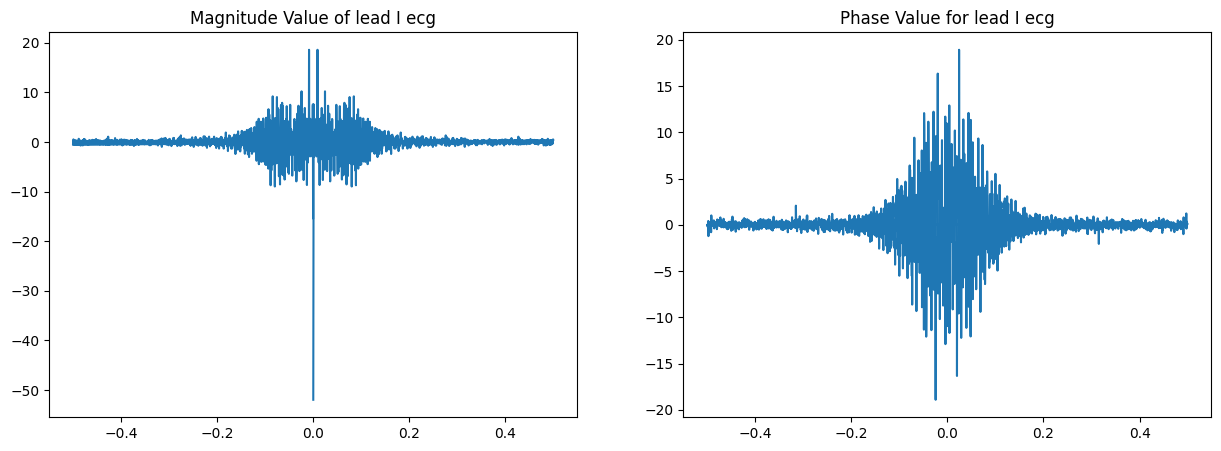

In [78]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(freq, freq_data.real)
plt.title('Magnitude Value of lead I ecg')

plt.subplot(1,2,2)
plt.plot(freq, freq_data.imag)
plt.title('Phase Value for lead I ecg')

<h4> Multi-channel Batch ECG FFT </h4>

In [85]:
batch_freq = np.fft.fftfreq(x.shape[1], 1/250)
batch_freq_data = np.fft.fft(x)

In [97]:
np.abs(batch_freq_data[0])

array([[0.17 , 0.15 ],
       [0.16 , 0.16 ],
       [0.155, 0.125],
       ...,
       [0.39 , 0.34 ],
       [0.395, 0.375],
       [0.395, 0.375]], shape=(2500, 2))

<h2> Model </h2>

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy

In [19]:
k1, p1 = 3, 1
k2, p2 = 5, 2
k3, p3 = 9, 4
k4, p4 = 17, 8
def my_permute(x, index): 
    y = x.reshape(x.shape[0], -1).detach().clone()  
    perm_index = torch.randperm(x.shape[0])
    for i in index:
        y[:, i] = y[perm_index, i]
    y = y.reshape(*x.size())  
    return y
def my_permute_new(x, index):
    y = deepcopy(x)
    perm_index = torch.randperm(x.shape[0])
    for i in index:
        y[:, i] = x[perm_index, i]
    return y
def my_freeze(x, index):  
    ori_size = x.size()
    x = x.reshape(x.shape[0], -1)
    x[:, index] = 0
    x = x.reshape(*ori_size)
    return x
def my_freeze_new(x, index): 
    y = x.clone()
    tmp_mean = x[:, index].mean(dim=0)
    y[:, index] = tmp_mean
    return y
def my_change(x, change_type, index):
    if change_type == 'permute':
        return my_permute_new(x, index)
    elif change_type == 'freeze':
        return my_freeze_new(x, index)
    else:
        raise ValueError("Undefined change_type")

In [20]:
class SELayer1D(nn.Module):
    def __init__(self, nChannels, reduction=16):
        super(SELayer1D, self).__init__()
        self.globalavgpool = nn.AdaptiveAvgPool1d(1)
        self.se_block = nn.Sequential(
            nn.Linear(nChannels, nChannels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(nChannels // reduction, nChannels, bias=False),
            nn.Sigmoid())
    def forward(self, x):
        alpha = torch.squeeze(self.globalavgpool(x))
        alpha = self.se_block(alpha)
        alpha = torch.unsqueeze(alpha, -1)
        out = torch.mul(x, alpha)
        return out
class BranchConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(BranchConv1D, self).__init__()
        C = out_channels // 4
        self.b1 = nn.Conv1d(in_channels, C, k1, stride, p1, bias=False)
        self.b2 = nn.Conv1d(in_channels, C, k2, stride, p2, bias=False)
        self.b3 = nn.Conv1d(in_channels, C, k3, stride, p3, bias=False)
        self.b4 = nn.Conv1d(in_channels, C, k4, stride, p4, bias=False)
    def forward(self, x):
        out = torch.cat([self.b1(x), self.b2(x), self.b3(x), self.b4(x)], dim=1)
        return out
class BasicBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, drop_out_rate, stride):
        super(BasicBlock1D, self).__init__()
        self.operation = nn.Sequential(
                BranchConv1D(in_channels, out_channels, stride),
                nn.BatchNorm1d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout(drop_out_rate),
                BranchConv1D(out_channels, out_channels, 1),
                nn.BatchNorm1d(out_channels),
                SELayer1D(out_channels))
        self.shortcut = nn.Sequential()
        if stride != 1:
            self.shortcut.add_module('MaxPool', nn.MaxPool1d(stride, ceil_mode=True))
        if in_channels != out_channels:
            self.shortcut.add_module('ShutConv', nn.Conv1d(in_channels, out_channels, 1))
            self.shortcut.add_module('ShutBN', nn.BatchNorm1d(out_channels))
    def forward(self, x):
        operation = self.operation(x)
        shortcut = self.shortcut(x)
        out = torch.relu(operation + shortcut)
        return out
class TEADNN(nn.Module):

    def __init__(self, num_classes=1, init_channels=1, growth_rate=16, base_channels=64,
                 stride=2, drop_out_rate=0.2):
        super(TEADNN, self).__init__()
        self.num_channels = init_channels
        block_n = 8
        block_c = [base_channels + i * growth_rate for i in range(block_n)]
        self.blocks = nn.Sequential()
        for i, C in enumerate(block_c):
            module = BasicBlock1D(self.num_channels, C, drop_out_rate, stride)
            self.blocks.add_module("block{}".format(i), module)
            self.num_channels = C
        module = nn.AdaptiveAvgPool1d(1)
        self.blocks.add_module("GlobalAvgPool", module)
        self.fc = nn.Linear(self.num_channels, num_classes)
    def get_feature_dim(self, place=None):
        feature_dim_list = [1 * 40 * 256, 32 * 128 * 126, 64 * 8 * 62, 128 * 7 * 14, 1024, 176, 1]
        return feature_dim_list[place] if place else feature_dim_list
    def forward(self, x, change_type=None, place=None, index=None):
        out = self.blocks(x)
        out1 = torch.squeeze(out)  
        if place == 5:
            out1 = my_change(out1, change_type, index)
        out2 = self.fc(out1)  
        return out2

In [21]:
model = TEADNN(num_classes=1, init_channels=2)
# model

In [29]:
dummmy_input = torch.rand(20, 2, 2500)
dummy_gt = torch.rand(64, 1)
model.eval()
with torch.no_grad():
    logits = model(dummmy_input)
logits.shape

torch.Size([20, 1])

In [ ]:
# pred = torch.sigmoid(logits)
# pred = torch.where(pred > 0.5, 1, 0)
# pred

[np.int64(10),
 np.int64(20),
 np.int64(30),
 np.int64(10),
 np.int64(20),
 np.int64(30)]

<h3> DataLoader </h3>

In [41]:
from torch.utils.data import Dataset, DataLoader
from typing import List

In [ ]:
class AFibDataset(Dataset):
    def __init__(self, path:str, file_names:List[str], window:int=2500, shift:int = 1250, transform=None):
        self.path = path
        self.file_names = file_names
        self.window = window
        self.shift = shift
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        x, y  = self.create_training_data(self.path, file_name, self.window, self.shift)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.int8)

    def create_training_data(self, path:str, file_name:str, window:int, shift:int):
        record_name = os.path.join(path, file_name)
        signal = wfdb.rdrecord(record_name)
        ann = wfdb.rdann(record_name, 'atr')
        boundary_idx = 0
        start, next_boundary = ann.sample[boundary_idx], ann.sample[boundary_idx]
        region = ann.aux_note[boundary_idx]
        data = []
        label = []
        while start+window < signal.p_signal.shape[0]:
            data.append(signal.p_signal[start:start+window, :])
            if not start < next_boundary < start + window:
                label.append(0) if region == '(N' else label.append(1)
            else:
                percent = (next_boundary - start)/window * 100
                if percent > 50:
                    label.append(0) if region == '(N' else label.append(1)
                else:
                    label.append(1) if region == '(N' else label.append(0)
            start += shift
            if start > ann.sample[boundary_idx]:
                region = ann.aux_note[boundary_idx]
                if boundary_idx + 1 < len(ann.sample):
                    boundary_idx += 1
            next_boundary = ann.sample[boundary_idx]
        
        data = np.array(data)
        label = np.array(label)
        if data.ndim != 3:
            data = np.expand_dims(data, axis=-1)
        return data, label

In [55]:
dataset = AFibDataset(path, files, 2500, 1250)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [56]:
x, y = next(iter(dataloader))
x = x.squeeze(dim=0).permute(0, 2, 1)
y = y.squeeze(dim=0)
x.shape, y.shape
# x.ndim

(torch.Size([7363, 2, 2500]), torch.Size([7363]))

<h2> Training Part </h2>

In [39]:
import pytorch_lightning as pl
import torch.nn.functional as F
from torchmetrics.classification import BinaryAccuracy
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [ ]:
class PrintCallback(Callback):
    def on_train_start(self, trainer, pl_module):
        print("Training started!")
    def on_train_end(self, trainer, pl_module):
        print("Training is done.")

checkpoint_callback = ModelCheckpoint(
    dirpath='/kaggle/working/model',
    filename=f"run 1 {{epoch}}-{{ssim:.2f}}",
    monitor='ssim',
    mode='max',
    save_top_k=1,
    save_last=True
)

In [ ]:
class AFibDataLoader(pl.LightningDataModule):
    def __init__(self, path, train_file, val_file, window, shift):
        super().__init__()
        self.train_file = train_file
        self.val_file = val_file
        self.transform = None

        self.path = path
        self.window = window
        self.shift = shift


    def setup(self, stage=None):
        if stage == 'fit':
            self.train_dataset = AFibDataset(self.path, self.train_file, self.window, self.shift)
            self.val_dataset = AFibDataset(self.path, self.train_file, self.window, self.shift)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=1, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=1, shuffle=False, num_workers=2)

In [ ]:
class AFibClassifier(pl.LightningModule):
    def __init__(self, model, batch_size, lr=1e-3):
        super().__init__()
        self.model = model
        self.batch_size = batch_size
        self.lr = lr
        self.automatic_optimization = False
        self.criterion = nn.BCEWithLogitsLoss()
        self.train_acc = BinaryAccuracy()
        self.val_acc = BinaryAccuracy()
        self.val_preds = []
        self.val_labels = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.squeeze(dim=0).permute(0, 2, 1)
        y = y.squeeze(dim=0)
        optim = self.optimizers()
        Loss, Acc = 0.0, 0.0
        for X, Y in self.generator(x, y, self.batch_size):
            logits = self(X).squeeze(1)
            loss = self.criterion(logits, Y.float())

            self.manual_backward(loss)
            optim.step()
            optim.zero_grad()

            preds = torch.sigmoid(logits)
            acc = self.train_acc(preds, Y.int())

            Loss += loss.item()
            Acc += acc
        self.log("train_loss", Loss/self.batch_size)
        self.log("train_acc", Acc/self.batch_size)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.squeeze(dim=0).permute(0, 2, 1)
        y = y.squeeze(dim=0)
        Loss, Acc = 0.0, 0.0
        for X, Y in self.generator(x, y, self.batch_size):
            logits = self(X).squeeze(1)
            loss = self.criterion(logits, Y.float())
            preds = torch.sigmoid(logits)
            acc = self.train_acc(preds, Y.int())
            Loss += loss.item()
            Acc += acc

            preds = torch.where(preds>0.5, 1, 0)
            self.val_preds.extend(preds.detach().cpu().numpy())
            self.val_labels.extend(Y.detach().cpu().numpy())
        self.log("val_loss", Loss/self.batch_size)
        self.log("val_acc", Acc/self.batch_size)
    
    def on_train_epoch_end(self):
        avg_train_loss = self.trainer.callback_metrics['train_loss']
        avg_train_acc = self.trainer.callback_metrics['train_acc']
        print(f"Train Loss: {avg_train_loss:.4f}")
        # print(f"Train Acc: {avg_train_acc:.4f}")
        

    def on_validation_epoch_end(self):
        avg_validation_loss = self.trainer.callback_metrics['val_loss']
        avg_validation_acc = self.trainer.callback_metrics['val_acc']
        report = classification_report(np.array(self.val_labels), np.array(self.val_preds), target_names=["Non-AF", "AF"])
        print(f"\nepoch: {self.current_epoch+1}")
        print("\nValidation Classification Report:\n", report)
        print(f"Valiadtion Loss : {avg_validation_loss:.4f}")
        # print(f"Valiadtion Acc : {avg_validation_acc:.4f}")
        self.val_labels = []
        self.val_preds = []
        

    def configure_optimizers(self):
        return {"optimizer":torch.optim.Adam(self.parameters(), lr=self.lr)}
    
    def generator(self, x, y, step):
        length = x.shape[0]
        start = 0
        while start < length:
            if start + step <= length:
                yield x[start:start + step], y[start:start + step]
            else:
                yield x[start:], y[start:]
                break
            start += step

In [ ]:

train_files, val_files = train_test_split(files, test_size=0.2, random_state=42, shuffle=True)
DATA_MODULE = AFibDataLoader(path, files, files, 2500, 1250)
MODEL_MODULE = AFibClassifier(model, 128)

In [ ]:
trainer = pl.Trainer(
    accelerator='auto', max_epochs=64,
    deterministic=True, callbacks=[PrintCallback()],
    limit_train_batches=5,
    limit_val_batches=5,
    num_sanity_val_steps=0
)

In [ ]:
trainer.fit(MODEL_MODULE, DATA_MODULE)

<h3> Checking Corrupted File </h3>

In [62]:
for file in files:
    record_name = os.path.join(path, file)
    hea_file = record_name + ".hea"
    dat_file = record_name + ".dat"
    atr_file = record_name + ".atr"

    if not os.path.exists(hea_file):
        raise FileNotFoundError(f"Missing header file: {hea_file}")
    if not os.path.exists(dat_file):
        raise FileNotFoundError(f"Missing data file: {dat_file}")
    if not os.path.exists(atr_file):
        raise FileNotFoundError(f"Missing annotation file: {atr_file}")

    try:
        signal = wfdb.rdrecord(record_name)
        ann = wfdb.rdann(record_name, 'atr')
    except Exception as e:
        raise RuntimeError(f"Failed to read record {record_name}: {e}")

In [ ]:
#Remove 